<a href="https://www.kaggle.com/code/veravarela/predict-survival-on-the-titanic?scriptVersionId=265327578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries and Others

## Libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Hide Warnings

In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Import and Load Data

## Import Data

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Train Data

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Load Test Data

In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis (EDA) - Train and Test Data

## Data Overview

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##### Analyzing the statistics of numerical variables: (i) the values of "Pclass" seems "normal" values - the min. and max. shows there is 3 classes; (ii) the values of  "Age" variables seems "normal" values too - the min. and max. have acceptable values (it not seem these variable have outliers but I'll check it in outliers step); (iii) the values of "SibSp" (# of Siblings/Spouses Aboard the Titanic) and "Parch" (# of Parents/Children Aboard the Titanic) don't look so good - it's weird to have 8 siblings in the trip, especially when most have 0, or have 6 children when most have 0 too (I'll check it in outliers step); (vi) I'll analyze the "Fare" values too in outliers step because the max. value is too big; (v) looking at the values of the counts it's possible see there is missing values for "Age" variable - I'll check it in missing values step.

In [7]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


##### Analyzing the statistics of categorical variables: (i) looking at the values of the counts it's possible see there is missing values for "Cabin" and "Embarked" variables - I'll check it in missing values step.

## Analyze the Correlation Between the Variables

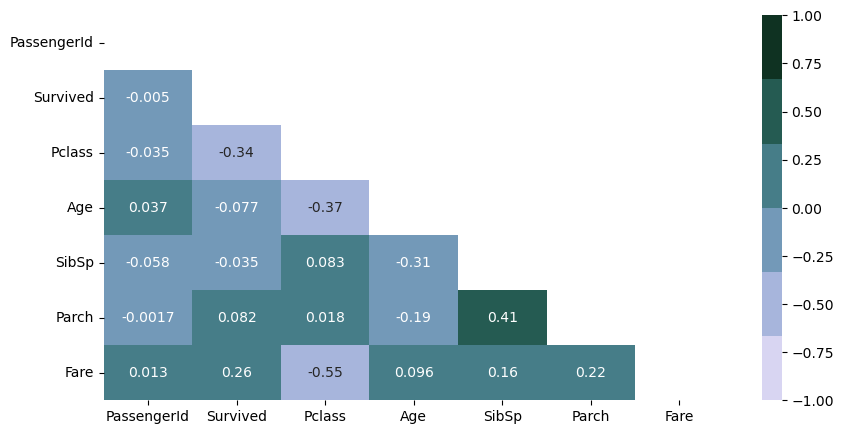

In [8]:
cmap=sns.cubehelix_palette(start=2)
mask = np.triu(np.ones_like(train_data.corr(), dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True, mask=mask, cmap=cmap);

##### Note: As we can see the variables are not very correlated - most of them have a correlation smaller than 30%. Only there is two pairs with a correlation bigger than 30% - Fare/Pclass and Parch/SibSp. In this work I'll keep all the variables. In a future, I'll analyze these pairs better (Fare/Pclass and Parch/SibSp) and exclude one of the two variables, within each pair, to see if it interferes with my prediction.

## Missing Values

### Searching for Missing Values - Train Data

In [9]:
train_data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

### Confirming Missing Values - Train Data

In [10]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##### Deal with missing values: (i) for "Age" variable, as it is a numeric variable and I have less than 1/4 of data missing, I'll change missing values by median; (ii) I will exclude "Cabin" variable because I have more than 3/4 of data missing - I can't use a variable that has so much missing data and I can drop these rows because I'll not have data for the analysis; (iii) I'll remove the rows that have missing values for "Embarked" if in test_data set there isn't missing values for "Embarked" variable - It's a categorical variable and I could try to know the value for these two rows, analyzing the other variables, but as it is just 2 in 891 I think the time I will waste analyzing and finding the values is not worth it.

In [11]:
test_data['Embarked'].count()

# there isn't missing values

418

### Deal With Missing Values - Train Data

#### Replace 'Age' Missing Values by 'Age' Median

In [12]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

#### Remove Rows with "Embarked" Missing Values

In [13]:
train_data[train_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
train_data.dropna(subset=['Embarked'], how='all', inplace=True)

### Searching for Missing Values - Test Data

In [15]:
test_data.count()

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64

### Deal with Missing Values - Test Data

#### Replace 'Age' Missing Values by 'Age' Median

In [16]:
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

#### Replace 'Fare' Missing Values by 'Fare' Median (for the same reason as I change "Age" missing values)

In [17]:
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

## Outliers

### Searching for Outliers - Train Data

In [18]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Age', '# of Siblings / Spouses Aboard the Titanic (SibSp)', '# of Parents / Children Aboard the Titanic (Parch)', 'Fare'))

fig.add_trace(go.Box(x=train_data['Age']),
              row=1, col=1)

fig.add_trace(go.Box(x=train_data['SibSp']),
              row=1, col=2)

fig.add_trace(go.Box(x=train_data['Parch']),
              row=2, col=1)

fig.add_trace(go.Box(x=train_data['Fare']),
              row=2, col=2)

fig.update_layout(height=500, width=1000, yaxis_visible=False, yaxis2_visible=False, yaxis3_visible=False, yaxis4_visible=False, showlegend=False)

fig.show()

##### Note: I will check the number of passengers with: (i) "Age" over 66 years old, (ii) "SibSp" over 5 and (iii) "Fare" over 300. I can't remove rows if the test_data dataset contains passengers with these characteristics, because I need to predict the survival of the 418 passengers present in the test_data dataset . So, if there is a small number of passengers with these characteristics (in train_data and test_data datasets) I will replace the values by the median, if there is a considerable number of passengers with these characteristics I will analyze them separately.

#### Check the Number of Passengers with "Age" over 66 years old, "SibSp" over 5 and "Fare" over 300 - Train and Test Data

In [19]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [20]:
train_data['Age'][train_data['Age'] > 66].count()

7

In [21]:
train_data['SibSp'][train_data['SibSp'] > 5].count()

7

In [22]:
train_data['Fare'][train_data['Fare'] > 300].count()

3

In [23]:
test_data['Age'][test_data['Age'] > 66].count()

2

In [24]:
test_data['SibSp'][test_data['SibSp'] > 5].count()

2

In [25]:
test_data['Fare'][test_data['Fare'] > 300].count()

1

### Deal with Outliers - Train Data

In [26]:
median_age = train_data['Age'].median()
train_data['Age'] = np.where(train_data['Age'] > 66, median_age,train_data['Age'])

In [27]:
median_sibsp = train_data['SibSp'].median()
train_data['SibSp'] = np.where(train_data['SibSp'] > 5, median_sibsp,train_data['SibSp'])

In [28]:
median_fare = train_data['Fare'].median()
train_data['Fare'] = np.where(train_data['Fare'] > 300, median_fare,train_data['Fare'])

### Deal with Outliers - Test Data

In [29]:
median_age = test_data['Age'].median()
test_data['Age'] = np.where(test_data['Age'] > 66, median_age,test_data['Age'])

In [30]:
median_sibsp = test_data['SibSp'].median()
test_data['SibSp'] = np.where(test_data['SibSp'] > 5, median_sibsp,test_data['SibSp'])

In [31]:
median_fare = test_data['Fare'].median()
test_data['Fare'] = np.where(test_data['Fare'] > 300, median_fare,test_data['Fare'])

## Transforming Variables

### Embarked Variable - Train Data

#### Analyze Embarked Data Type

In [32]:
print(train_data['Embarked'].unique())

['S' 'C' 'Q']


#### Create a New Column with the Port Embarkation

In [33]:
train_data['Port_Embarkation'] = np.where(train_data['Embarked'].astype(str).str[0] == 'C', 'C',
                                 np.where(train_data['Embarked'].astype(str).str[0] == 'Q', 'Q',
                                 np.where(train_data['Embarked'].astype(str).str[0] == 'S', 'S',
                                 'NaN')))

#### Count the Number of Passengers by Port Embarkation

In [34]:
train_data.groupby(['Port_Embarkation'])['PassengerId'].count()

Port_Embarkation
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

### Embarked Variable - Test Data

#### Create a New Column with the Port Embarkation

In [35]:
test_data['Port_Embarkation'] = np.where(test_data['Embarked'].astype(str).str[0] == 'C', 'C',
                                np.where(test_data['Embarked'].astype(str).str[0] == 'Q', 'Q',
                                np.where(test_data['Embarked'].astype(str).str[0] == 'S', 'S',
                                'NaN')))

#### Count the Number of Passengers by Port Embarkation

In [36]:
test_data.groupby(['Port_Embarkation'])['PassengerId'].count()

Port_Embarkation
C    102
Q     46
S    270
Name: PassengerId, dtype: int64

# Modeling - Choose the Model

## Features to Consider

In [37]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Port_Embarkation']

train = train_data[features]
test = test_data[features]

## Transform Categorical Variables into Numeric Variables

In [38]:
X_train = pd.get_dummies(train)
y_train = train_data['Survived']

X_test = pd.get_dummies(test)

### Confirm If I Have the Same Number of Rows in Both Datasets

In [39]:
print(len(X_train.columns))
print(len(X_test.columns))

10
10


## Run some Models to Choose the Best One

##### Note: to choose I'll use 'accuracy', 'precision' and 'neg_mean_squared_error scores

In [40]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

models = [LogisticRegression(random_state=20), 
          DecisionTreeClassifier(random_state=20),
          KNeighborsClassifier(n_neighbors=5),
          SVC(random_state=20),
          RandomForestClassifier(random_state=20),
          xgb.XGBClassifier(random_state=20)]

names = ['LogisticRegression', 'Decision Tree', 'K Neighbors','SVC','Random Forest','XGBoost']

for model, name in zip(models, names):
    print(name)
    for score in ['accuracy', 'precision', 'neg_mean_squared_error']:
        result = cross_val_score(model, X_train, y_train, scoring=score, cv=cv)
        print(score,': %.4f (%.3f)' % (np.mean(result), np.std(result)))
    print('\r\n')

LogisticRegression
accuracy : 0.7896 (0.036)
precision : 0.7340 (0.055)
neg_mean_squared_error : -0.2104 (0.036)


Decision Tree
accuracy : 0.7829 (0.037)
precision : 0.7294 (0.098)
neg_mean_squared_error : -0.2171 (0.037)


K Neighbors
accuracy : 0.7086 (0.040)
precision : 0.6340 (0.056)
neg_mean_squared_error : -0.2914 (0.040)


SVC
accuracy : 0.6658 (0.057)
precision : 0.6655 (0.133)
neg_mean_squared_error : -0.3342 (0.057)


Random Forest
accuracy : 0.8065 (0.028)
precision : 0.7567 (0.073)
neg_mean_squared_error : -0.1935 (0.028)


XGBoost
accuracy : 0.8189 (0.022)
precision : 0.7772 (0.066)
neg_mean_squared_error : -0.1811 (0.022)




##### Note: best models was Random Forest and XGBoost so I'll use them in the next step

# Modeling - Hyperparameter Tuning using Randomized Search Type

## Random Forest Classifier Model

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

param_space = {'n_estimators': [20,40,60,80,100,120,140,160],
               'criterion': ['gini', 'entropy', 'log_loss'],
               'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
               'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.10],
               'max_features': ['sqrt', 'log2', None],
               'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
               'min_impurity_decrease': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'verbose' : [0],
               'max_samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
               }

rfc = RandomForestClassifier()


rfc_randomsearch = RandomizedSearchCV(rfc, param_space, scoring='accuracy', cv=5, random_state = 10)

rfc_randomsearch.fit(X_train, y_train)

print(rfc_randomsearch.best_params_)

print('Accuracy with hyperparameter tuning Randomized Search: %.2f' % ( rfc_randomsearch.best_score_))
# 62%

{'verbose': 0, 'n_estimators': 20, 'min_weight_fraction_leaf': 0.3, 'min_samples_split': 6, 'min_samples_leaf': 10, 'min_impurity_decrease': 9, 'max_samples': 3, 'max_leaf_nodes': 4, 'max_features': None, 'max_depth': 9, 'criterion': 'entropy'}
Accuracy with hyperparameter tuning Randomized Search: 0.62


## XGBoost Model

In [42]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

param_space = {'booster': ['gbtree', 'dart'],
               'verbosity' : [0],
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
               }

xgbclass = xgb.XGBClassifier()


xgbclass_randomsearch = RandomizedSearchCV(xgbclass, param_space, scoring='accuracy', cv=5, random_state = 10)

xgbclass_randomsearch.fit(X_train, y_train)

print(xgbclass_randomsearch.best_params_)

print('Accuracy with hyperparameter tuning Randomized Search: %.2f' % ( xgbclass_randomsearch.best_score_))
# 83%

{'verbosity': 0, 'max_depth': 3, 'booster': 'dart'}
Accuracy with hyperparameter tuning Randomized Search: 0.83


##### Note: the best model, after the hyperparameter tuning, was XGBoost with 83% of accuracy.

# Modeling - Applying the Best Model (XGBoost)

In [43]:
best_model = xgb.XGBClassifier(verbosity = 0, max_depth = 4, booster = 'gbtree', random_state=20)
best_model.fit(X_train, y_train)
y_predict = best_model.predict(X_test)

# Analyze the Results

## Big Picture

In [44]:
results = test_data
results['Survived_Predict'] = pd.DataFrame(y_predict)
results

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Port_Embarkation,Survived_Predict
0,892,3,"Kelly, Mr. James",male,34.5,0.0,0,330911,7.8292,NaN,Q,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1.0,0,363272,7.0000,NaN,S,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0.0,0,240276,9.6875,NaN,Q,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0.0,0,315154,8.6625,NaN,S,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1.0,1,3101298,12.2875,NaN,S,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0.0,0,A.5. 3236,8.0500,NaN,S,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0.0,0,PC 17758,108.9000,C105,C,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0.0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,S,0
416,1308,3,"Ware, Mr. Frederick",male,27.0,0.0,0,359309,8.0500,NaN,S,S,0


In [45]:
results.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived_Predict
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,29.386364,0.409091,0.392344,34.385447,0.418660
std,120.810458,0.841838,12.363459,0.728069,0.981429,50.732774,0.493931
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,35.000000,1.000000,0.000000,31.387500,1.000000
max,1309.000000,3.000000,64.000000,5.000000,9.000000,263.000000,1.000000


## How many I predict survived?

In [46]:
survivors_count = results.loc[results['Survived_Predict'] == 1, 'PassengerId'].count()
total = results['Survived_Predict'].count()

print(f'Survived {survivors_count} ({(survivors_count/total*100).round(decimals=1)}%) passengers, out of a total of {total}.')

Survived 175 (41.9%) passengers, out of a total of 418.


## Who I predict survived?

[Text(0.5, 1.0, 'Port Embarkation'), Text(87.59722222222221, 0.5, 'Survivors')]

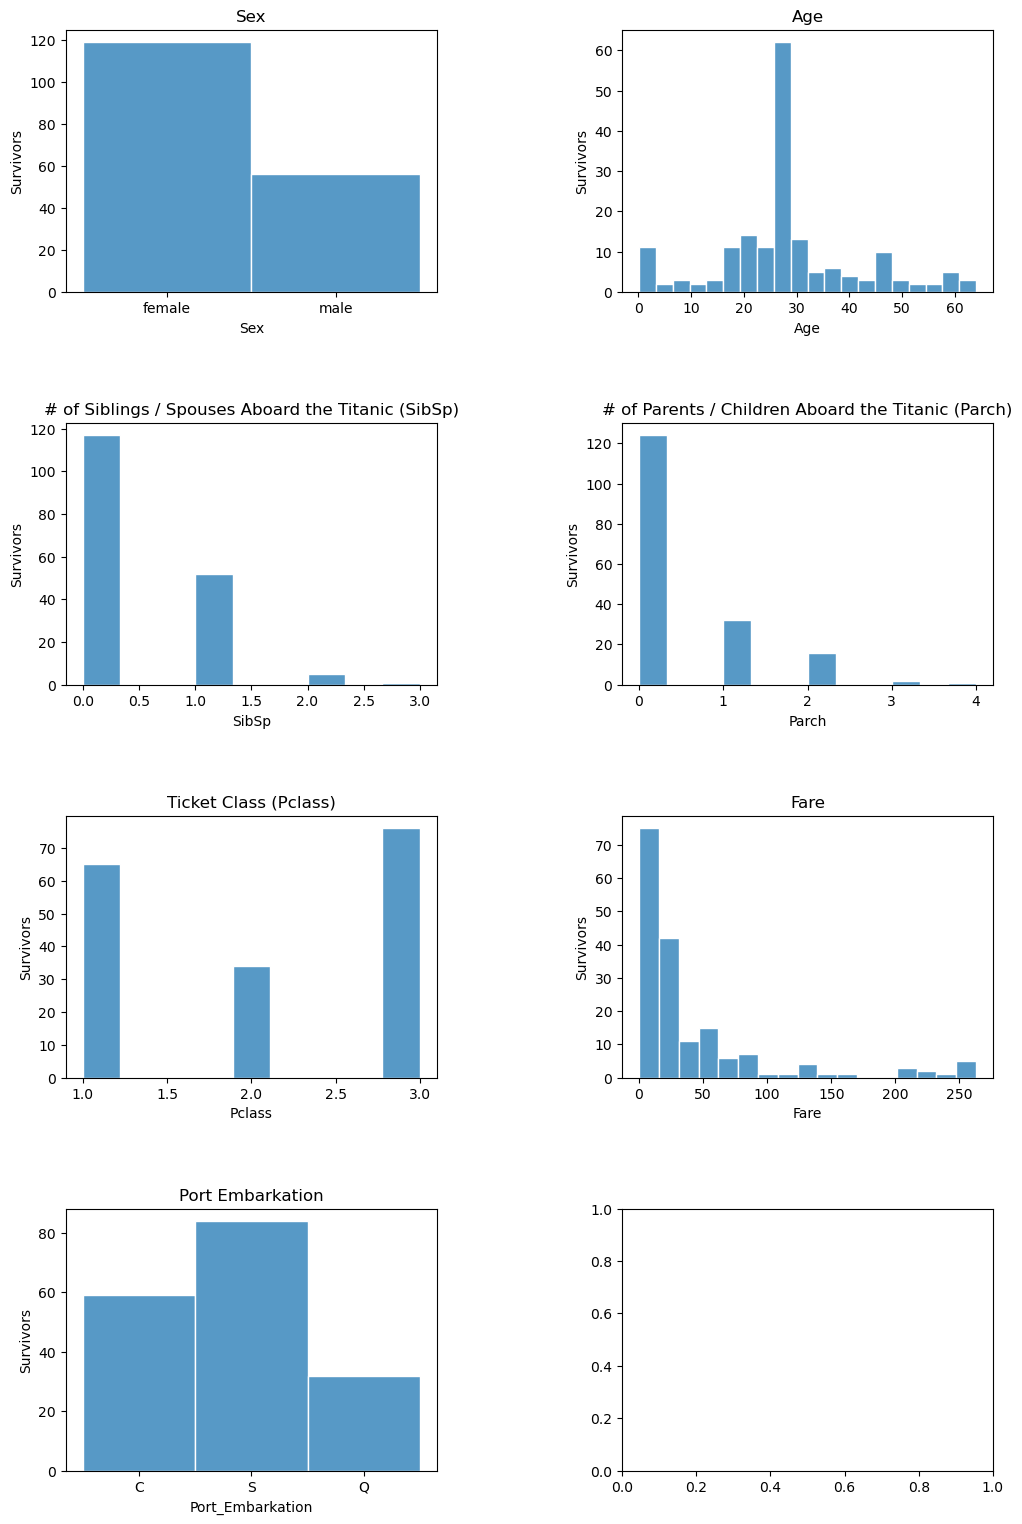

In [47]:
# survivors predicted 
survivors = pd.DataFrame(results.loc[results['Survived_Predict'] == 1])

# graphs
window, graphs = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.set_theme(style='dark')

ax1 = sns.histplot(data=survivors, x='Sex', ax=graphs[0][0])
ax2 = sns.histplot(data=survivors, x='Age', ax=graphs[0][1])
ax3 = sns.histplot(data=survivors, x='SibSp', ax=graphs[1][0])
ax4 = sns.histplot(data=survivors, x='Parch', ax=graphs[1][1])
ax5 = sns.histplot(data=survivors, x='Pclass', ax=graphs[2][0])
ax6 = sns.histplot(data=survivors, x='Fare', ax=graphs[2][1])
ax8 = sns.histplot(data=survivors, x='Port_Embarkation', ax=graphs[3][0])

ax1.set(title='Sex', ylabel='Survivors')
ax2.set(title='Age', ylabel='Survivors')
ax3.set(title='# of Siblings / Spouses Aboard the Titanic (SibSp)', ylabel='Survivors')
ax4.set(title='# of Parents / Children Aboard the Titanic (Parch)', ylabel='Survivors')
ax5.set(title='Ticket Class (Pclass)', ylabel='Survivors')
ax6.set(title='Fare', ylabel='Survivors')
ax8.set(title='Port Embarkation', ylabel='Survivors')

# Output in .csv File

In [48]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_predict})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
